# Batch Processing of Plots using the Selection for Data

NUE SELECTION

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

/home/alex/NuMI/PELEE/


In [3]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

In [4]:
params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

## NUE_NUE SAMPLE

In [4]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
#full sample
NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune

#actually fetch datasets
nue_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_nue]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)

['shr_tkfit_npoints', 'trk_score_v', 'shrsubclusters0', 'category', 'reco_nu_vtx_sce_z', 'shr_tkfit_nhits_Y', 'slnunhits', 'shr_phi', 'shr_px', 'shrmoliereavg', 'nu_pdg', 'sub', 'n_showers_contained', 'nproton', 'shr_distance', 'shr_score', 'evt', 'npion', 'shr_energy_cali', 'shr_tkfit_dedx_U', 'shr_tkfit_nhits_U', 'reco_nu_vtx_sce_y', 'shr_pz', 'shr_tkfit_dedx_V', 'ccnc', 'n_showers', 'flash_time', 'hits_ratio', 'shr_tkfit_nhits_V', 'shr_tkfit_dedx_Y', 'trkshrhitdist2', 'shr_py', 'reco_nu_vtx_sce_x', 'shr_theta', 'n_tracks', 'selected', 'shr_energy_tot_cali', 'CosmicIPAll3D', 'shrsubclusters1', 'nslice', 'contained_fraction', 'trk_energy_tot', 'tksh_angle', 'slnhits', 'tksh_distance', 'topological_score', 'shr_energy', 'run', 'n_tracks_contained', 'shrsubclusters2', 'trk_energy']


In [5]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_nue]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [6]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_nue]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [7]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [8]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [9]:
#This assumes the electron to be the leading shower

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [10]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_nue]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  21.307329654693604


In [11]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [12]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    

In [13]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_nue]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])


In [14]:
# add back the cosmic category, for background only
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    

In [15]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_nue]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [16]:
#Define signal catagories

nue_nue["is_signal"] = nue_nue["category"] == 11

In [17]:
# Some quick clean up since some strange events get in there
nue_nue   = nue_nue.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_nue]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [18]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

Set up complete. Set up BDT for Selection.

In [19]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [20]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [21]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_nue]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(127551, 125)


In [22]:
datasets_bdt = nue_nue

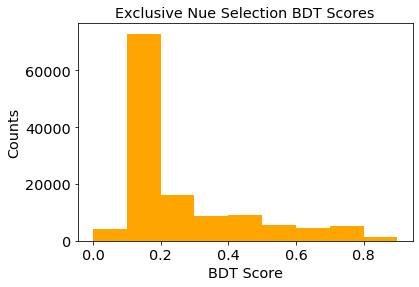

In [23]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [24]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'

Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  127551

1.0
1
{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_nue
1
2
3
current_total  65.24917734077063
[0.008804630377731826, 0.0, 0.01666347915882227]

SUMS
[0.42509096619460385, 4.448946788351456, 8.195002935651873, 65.24917734077084]
[4.023855822156852, 3.7460561473004166, 57.05417440511897]

Wanted List:
[1.1528940335090323, 1.6232998212107164, 0.5814167565939227, 0.2732157749613511, 0.08132464983309351, 0.033905111192300996, 0.0, 0.0, 0.0, 0.0]

current_wanted_list  [1.1528940335090323, 1.6232998212107164, 0.5814

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Returning
{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_nue
Had to return early (colour sorting).


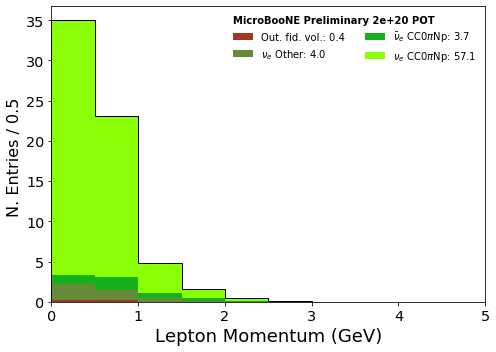

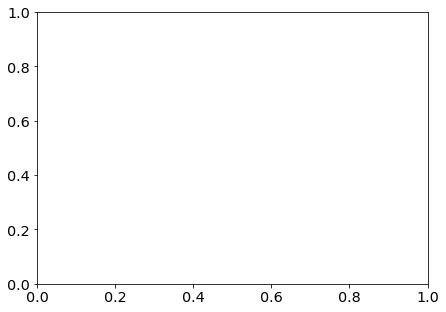

In [25]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "nue_nue": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    nueratio  = pot/2.37838e+22 

    # NUE
    weights = { #full sample mc = 0.38
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
No handles with labels found to put in legend.


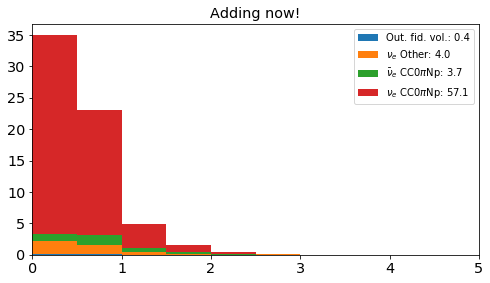

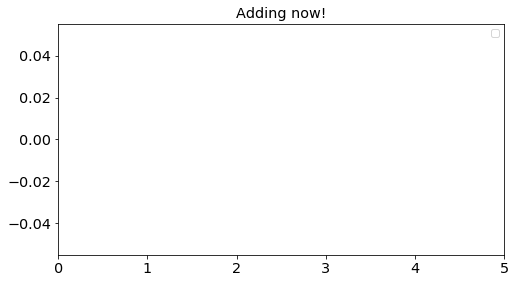

In [26]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [27]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

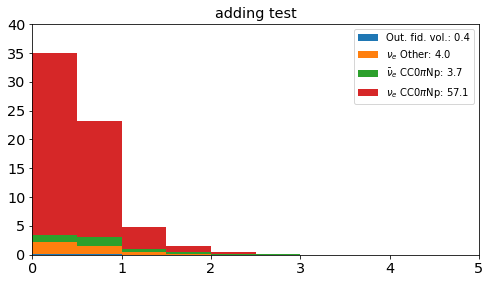

In [28]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 40])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 35])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [29]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 2

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[0.008804630377731826, 0.0, 0.01666347915882227]

SUMS
[0.42509096619460385, 4.448946788351456, 8.195002935651873, 65.24917734077084]
[4.023855822156852, 3.7460561473004166, 57.05417440511897]

Wanted List:
[31.59230370991931, 19.998428719382698, 3.8132490387973945, 1.1686316366886658, 0.3513423070225272, 0.06354530101689448, 0.029862536015414776, 0.02014767711723664, 0.01666347915882227, 0.0]

[31.59230370991931, 19.998428719382698, 3.8132490387973945, 1.1686316366886658, 0.3513423070225272, 0.06354530101689448, 0.029862536015414776, 0.02014767711723664, 0.01666347915882227, 0.0]


In [74]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)


######full trueE
#vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_recoE_usingSelection.csv')
#weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_recoE_usingSelection.csv')
########angleDiff
#vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
#weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
########leptonMom
#vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
#weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')

### Stat Errors

In [38]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= truthsel_nue,
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  127551

3.188775
3
{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_nue

err nue: 
[0.00127283 0.00219209 0.00296993 0.00487918 0.00544488 0.00770769
 0.01195045 0.01937528 0.03217428 0.06774278]
detsys nue: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0.13338654 0.25882378 0.34744942 0.6166311  0.7362064  0.9034545
 1.6615738  2.4217818  4.407571   9.510452  ]
Returning
{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 an

In [39]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

nue_nue_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_nue_stat_errs_selected = total_sels

total errs =  [0.004737751803889967, 0.007141984062580398, 0.010394768883161569, 0.012516150287888422, 0.017183189378287493, 0.026729405699558322, 0.03783130171762884, 0.060176519180751675, 0.10217987099434332, 0.20853179208464942]
total selected =  [0.5628387425094843, 0.8673024885356426, 1.2910888493061066, 1.6545333117246628, 2.206775024533272, 3.3514479249715805, 4.964785546064377, 7.693452954292297, 13.728691101074219, 28.928258895874023]


In [40]:
"""
np.savetxt("nue_nue_stat_errs_full_catsel_nopions_recoE_usingSelection.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_recoE_usingSelection.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')


"""

#########################
#####angleDiff###########
##########################

np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')


"""
#########################
#####leptonMom###########
##########################

np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""

'\n#########################\n#####leptonMom###########\n##########################\n\nnp.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", \n           nue_nue_stat_errs,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", \n           nue_nue_stat_errs_selected,\n           delimiter =", ", \n           fmt =\'% s\')\n'

### Sys Errors

In [50]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsPPFX",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)

n_events here =  127551

3.188775
3
{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & 

In [51]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_nue_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [52]:
"""
np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ns_nue_nue_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ncvs_nue_nue_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection.csv')
total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection.csv')
total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection.csv')
"""

"""
#################################
#####angleDiff##################
############################

np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_nue_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_nue_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""

#################################
#####leptonMom##################
############################

np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_nue_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_nue_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')


In [53]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsGenie",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)

n_events here =  127551

3.188775
3
{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & 

In [54]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_genie.append(sum(masterlist[a]))

final_ncvs_nue_nue_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [55]:
"""
np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ns_nue_nue_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ncvs_nue_nue_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection.csv')
total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection.csv')
total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection.csv')

"""
"""

#####################
###AngleDiff###
######################
np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_nue_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_nue_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""

#####################
###leptonMom###
######################
np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_nue_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_nue_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')


In [56]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("weightsReint")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsReint",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)

n_events here =  127551
weightsReint
1.0
1
{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon 

In [57]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_reint.append(sum(masterlist[a]))

final_ncvs_nue_nue_reint = sum(n_cv_tots)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)

In [58]:
"""
np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ns_nue_nue_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ncvs_nue_nue_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection.csv')
total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection.csv')
total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection.csv')
"""

"""
#################
###angleDiff#####
#################

np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_nue_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_nue_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""


#################
###leptonMom#####
#################

np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_nue_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_nue_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')


In [59]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
batch_size = 20000

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_nue",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)

n_events here =  127551
6.37755
7
{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targ

In [60]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_geo.append(sum(masterlist[a]))

final_ncvs_nue_nue_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_nue_geo)):
    final_ns_nue_nue_geo[x] = np.concatenate((final_ns_nue_nue_geo[x][0], final_ns_nue_nue_geo[x][1]))
    
    
#print(final_ns_nue_nue_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [61]:
"""
np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection.csv", 
           final_ns_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection.csv", 
           final_ncvs_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_recoE_usingSelection.csv')
total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection.csv')
total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection.csv')

"""

"""
#####################
###angleDiff########
####################

np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection.csv')
total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection.csv')
total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection.csv')
"""

#####################
###leptonMom########
####################

np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv')


## NUE_MC SAMPLE

In [4]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#full sample
NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune

#actually fetch datasets
nue_mc  = uproot.open(ls.ntuple_path+NU+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_mc]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_mc  = nue_mc.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)

['hits_ratio', 'n_tracks', 'trk_score_v', 'shr_theta', 'shr_tkfit_nhits_V', 'slnhits', 'tksh_angle', 'trk_energy_tot', 'reco_nu_vtx_sce_z', 'shr_energy_tot_cali', 'shr_tkfit_nhits_U', 'shrsubclusters2', 'n_showers_contained', 'shrsubclusters0', 'reco_nu_vtx_sce_y', 'CosmicIPAll3D', 'sub', 'trkshrhitdist2', 'n_tracks_contained', 'shr_phi', 'shr_tkfit_dedx_Y', 'shr_py', 'npion', 'shrsubclusters1', 'reco_nu_vtx_sce_x', 'topological_score', 'shr_energy', 'ccnc', 'nproton', 'n_showers', 'shr_energy_cali', 'category', 'nu_pdg', 'evt', 'contained_fraction', 'flash_time', 'tksh_distance', 'shr_distance', 'shr_score', 'shrmoliereavg', 'shr_tkfit_dedx_V', 'shr_px', 'shr_tkfit_dedx_U', 'trk_energy', 'run', 'shr_pz', 'slnunhits', 'selected', 'nslice', 'shr_tkfit_npoints', 'shr_tkfit_nhits_Y']


In [5]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_mc]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [6]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_mc]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [7]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [8]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [9]:
#This assumes the electron to be the leading shower

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [10]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_mc]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  153.8109130859375


In [11]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [12]:
df_v = [nue_mc]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']  

In [13]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_mc]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])

In [14]:
# add back the cosmic category, for background only
df_v = [nue_mc]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [15]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_mc]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [16]:
#Define signal catagories

nue_mc["is_signal"] = nue_mc["category"] == 11

In [17]:
# Some quick clean up since some strange events get in there
nue_mc   = nue_mc.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_mc]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
   

In [18]:
df_v = [nue_mc]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

Set up complete. Set up BDT for selection.

In [19]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [20]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [21]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_mc]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(914729, 125)


In [22]:
datasets_bdt = nue_mc

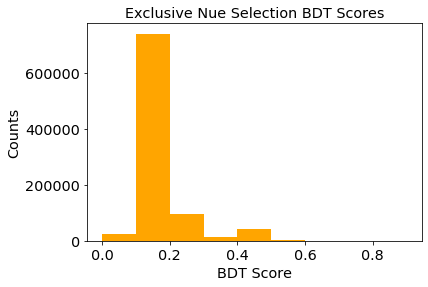

In [23]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [24]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'

Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  914729

1.0
1
{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_mc
1
2
3
current_total  6.406481953009317
[0.0, 0.0, 0.0, 0.0, 0.0]

SUMS
[0.09383747909215713, 0.5667739784442256, 1.0992005877360693, 2.06868340235577, 3.7175315201278423, 6.406481953009316]
[0.4729364993520685, 0.5324266092918437, 0.9694828146197008, 1.6488481177720722, 2.688950432881474]

Wanted List:
[0.2540986628912244, 0.18274319499862185, 0.05040179700898623, 0.04518295439301101, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

current_wanted_list  [0.2540986628912244, 0

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Returning
{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_mc
Had to return early (colour sorting).


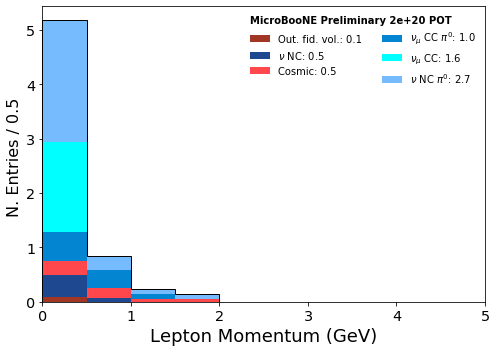

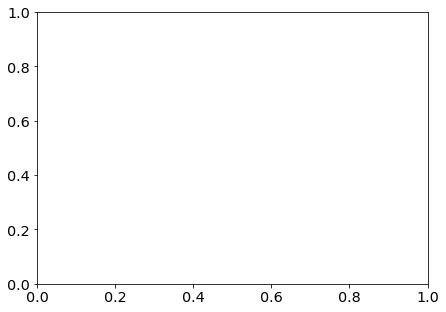

In [25]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    # This is the full MC POT scaling factor
    mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21

    # NU
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
No handles with labels found to put in legend.


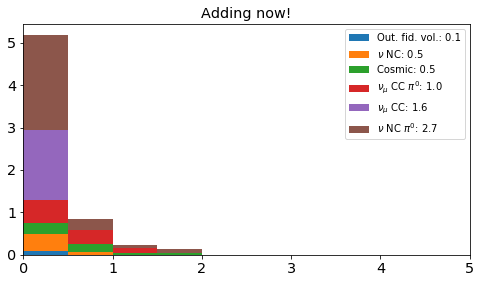

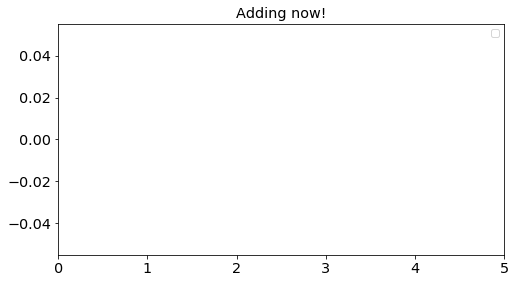

In [26]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [27]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

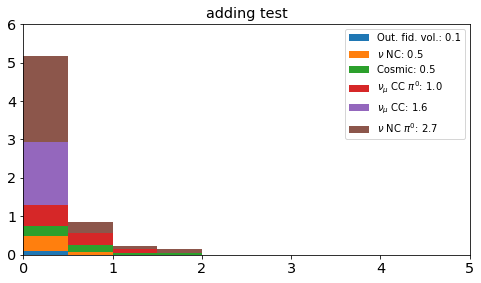

In [28]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 6])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 2])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [29]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 2

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[0.0, 0.0, 0.0, 0.0, 0.0]

SUMS
[0.09383747909215713, 0.5667739784442256, 1.0992005877360693, 2.06868340235577, 3.7175315201278423, 6.406481953009316]
[0.4729364993520685, 0.5324266092918437, 0.9694828146197008, 1.6488481177720722, 2.688950432881474]

Wanted List:
[0.5461423786619994, 0.3210504859955792, 0.10228994996212237, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

[0.5461423786619994, 0.3210504859955792, 0.10228994996212237, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [52]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)


######full trueE
#vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_recoE_usingSelection.csv')
#weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_recoE_usingSelection.csv')
########angleDiff
#vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
#weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
########leptonMom
#vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
#weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')

### Stat Errors

In [38]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= truthsel_nue,
        currentsample = "nue_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  914729

22.868225
22
{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_mc

err nue mc: 
[0.         0.         0.         0.         0.         0.
 0.00732691 0.         0.         0.        ]
detsys nue mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0.         0.         0.         0.         0.         0.
 0.02976912 0.         0.         0.        ]
Returning
{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_

{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_mc

err nue mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys nue mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Returning
{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 


In [39]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

nue_mc_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_mc_stat_errs_selected = total_sels

total errs =  [0.03663456086142664, 0.007326912172285328, 0.021980736516855982, 0.029307648689141312, 0.04396147303371197, 0.03663456086142664, 0.06594220955056795, 0.08059603389513861, 0.08059603389513861, 0.14653824344570657]
total selected =  [0.37117934599518776, 0.10911332070827484, 0.3192881569266319, 0.2276520535092459, 0.8247174359858036, 0.44738174974918365, 0.5267367500428577, 0.8427172314917248, 0.7174276281148195, 1.657368265092373]


In [40]:
"""
np.savetxt("nue_mc_stat_errs_full_catsel_nopions_recoE_usingSelection.csv", 
           nue_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_recoE_usingSelection.csv", 
           nue_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

"""


#########################
#####angleDiff###########
##########################

np.savetxt("nue_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
           nue_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
           nue_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')



#########################
#####leptonMom###########
##########################
"""
np.savetxt("nue_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""

'\nnp.savetxt("nue_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", \n           nue_mc_stat_errs,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", \n           nue_mc_stat_errs_selected,\n           delimiter =", ", \n           fmt =\'% s\')\n'

### Sys Errors

In [31]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        typeerr = "standard",
        weight = "weightsPPFX",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)

n_events here =  914729

22.868225
22
{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
extra query added.
Returning
--------------------------

{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

Returning
--------------------------

{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
extra query added.
Returning
--------------------------

{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

In [32]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_mc_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [33]:
"""
np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ns_nue_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ncvs_nue_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection.csv')
total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection.csv')
#####this was a typo, but think is fine
total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE.csv')

"""

#################################
#####angleDiff##################
############################

np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDif_usingSelectionf.csv')
total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')

"""
#################################
#####leptonMom##################
############################

np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

'\n#################################\n#####leptonMom##################\n############################\n\nnp.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ns_nue_mc_ppfx[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", \n           final_ncvs_nue_mc_ppfx,\n           delimiter =", ", \n           fmt =\'% s\')\n\n#np.savetxt("nue_nue_syserss_df_ppfx.csv", \n#           df_nue_nue_ppfx,\n#           delimiter =", ", \n#           fmt =\'% s\')\n\n###########################################\n\ntotal_ppfx_df.to_csv(\'nue_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_ppfx_df_vars.to_csv(\'nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv\')\ntotal_ppfx_df_splines.to_csv(\'nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.

In [40]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }  


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        typeerr = "standard",
        weight = "weightsGenie",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)

n_events here =  914729

22.868225
22
{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
extra query added.
Returning
--------------------------

{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targe

Returning
--------------------------

{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
extra query added.
Returning
--------------------------

{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targe

In [41]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_genie.append(sum(masterlist[a]))

final_ncvs_nue_mc_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)

In [42]:
"""
np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ns_nue_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ncvs_nue_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection.csv')
total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection.csv')
total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection.csv')
"""

"""
#####################
###AngleDiff###
######################
np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""

#####################
###leptonMom###
######################
np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')


In [49]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("weightsReint")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        typeerr = "standard",
        weight = "weightsReint",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)

n_events here =  914729
weightsReint
1.0
1
{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
extra query added.
Returning
--------------------------

{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& 

In [50]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_reint.append(sum(masterlist[a]))

final_ncvs_nue_mc_reint = sum(n_cv_tots)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)


In [52]:
"""
np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ns_nue_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ncvs_nue_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection.csv')
total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection.csv')
total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection.csv')
"""
"""

#################
###angleDiff#####
#################

np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDif_usingSelectionf.csv", 
           final_ncvs_nue_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""


#################
###leptonMom#####
#################

np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')


In [59]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
batch_size = 20000

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)

n_events here =  914729
45.73645
46
{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& target

Returning
--------------------------

{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targ

Returning
--------------------------

{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_mc': 0.08559738414394057}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targ

In [60]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_geo.append(sum(masterlist[a]))

final_ncvs_nue_mc_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_mc_geo)):
    final_ns_nue_mc_geo[x] = np.concatenate((final_ns_nue_mc_geo[x][0], final_ns_nue_mc_geo[x][1]))
    
    
#print(final_ns_nue_nue_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [61]:
"""
np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection.csv", 
           final_ns_nue_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection.csv", 
           final_ncvs_nue_mc_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_recoE_usingSelection.csv')
total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection.csv')
total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection.csv')
"""

"""
#####################
###angleDiff########
####################

np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_mc_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection.csv')
total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection.csv')
total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection.csv')
"""

#####################
###leptonMom########
####################

np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_mc_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv')


## NUE_DIRT SAMPLE

In [4]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
#full sample
DRT  = '/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND

#actually fetch datasets
nue_dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_dirt]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_dirt = nue_dirt.pandas.df(nue_variables+nue_varMC + WEIGHTS + SYSTEMATICS, flatten=False)

['shr_energy_tot_cali', 'evt', 'trk_score_v', 'reco_nu_vtx_sce_x', 'shrmoliereavg', 'nproton', 'nu_pdg', 'selected', 'shr_energy_cali', 'run', 'shr_px', 'reco_nu_vtx_sce_z', 'tksh_distance', 'topological_score', 'shrsubclusters2', 'shr_distance', 'shr_phi', 'trk_energy_tot', 'shr_score', 'n_tracks', 'shrsubclusters0', 'hits_ratio', 'shr_energy', 'category', 'tksh_angle', 'slnunhits', 'flash_time', 'shrsubclusters1', 'shr_py', 'n_showers_contained', 'n_showers', 'sub', 'npion', 'nslice', 'trkshrhitdist2', 'shr_pz', 'shr_tkfit_dedx_U', 'contained_fraction', 'shr_tkfit_nhits_U', 'slnhits', 'shr_tkfit_dedx_Y', 'n_tracks_contained', 'shr_tkfit_nhits_Y', 'shr_tkfit_npoints', 'reco_nu_vtx_sce_y', 'shr_tkfit_dedx_V', 'CosmicIPAll3D', 'ccnc', 'shr_theta', 'trk_energy', 'shr_tkfit_nhits_V']


In [5]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_dirt]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [6]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_dirt]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [7]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [8]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [9]:
#This assumes the electron to be the leading shower

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [10]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_dirt]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  55.638915061950684


In [11]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [12]:
df_v = [nue_dirt]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']  

In [13]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_dirt]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])

In [14]:
# add back the cosmic category, for background only
df_v = [nue_dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [15]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_dirt]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [16]:
#Define signal catagories

nue_dirt["is_signal"] = nue_dirt["category"] == 11

In [17]:
# Some quick clean up since some strange events get in there
nue_dirt   = nue_dirt.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
   

Set up complete. Set up BDT for selection.

In [18]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [19]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [20]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_dirt]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(483722, 107)


In [21]:
datasets_bdt = nue_dirt

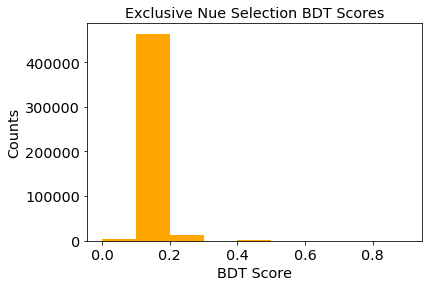

In [22]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [23]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'

Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  483722

1.0
1
{'nue_dirt': 0.049246181662128984}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_dirt
1
2
3
current_total  0.030014596239324537
[]

SUMS
[]
[]

Wanted List:
[]

current_wanted_list  []
current_total_hist  [0.0300146 0.        0.        0.        0.        0.        0.
 0.        0.        0.       ]

current n_tot  [0.0300146 0.        0.        0.        0.        0.        0.
 0.        0.        0.       ]
total array  [0.10224859]
total weight array  [0.0300146]
Returning
{'nue_dirt': 0.049246181662128984}
nslice==1 and 10<=reco_nu_v

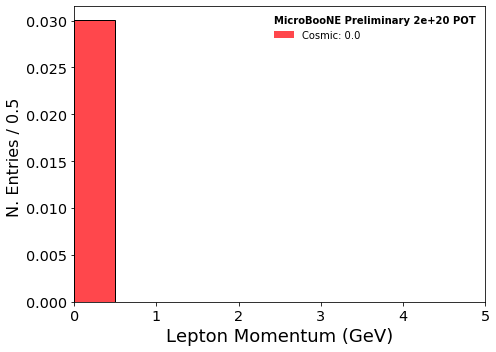

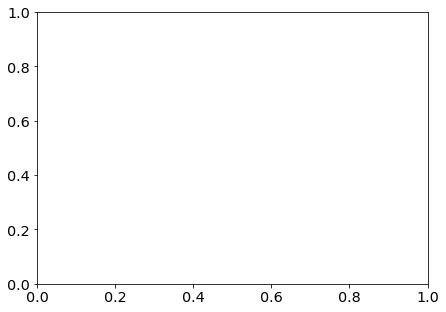

In [61]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    # This is the POT scaling factor for dirt sample
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.35

    # NU
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


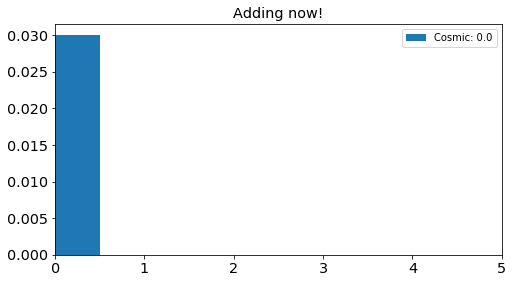

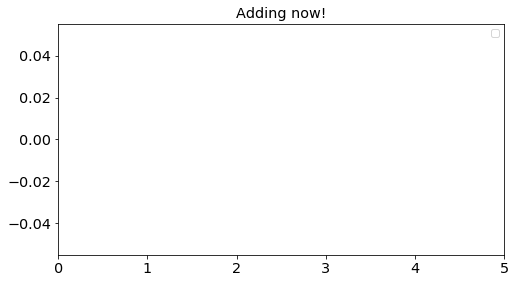

In [62]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [63]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

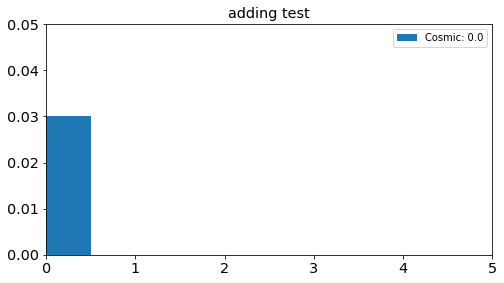

In [64]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 0.05])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 0.05])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [65]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 2

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [49]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)


######full trueE
#vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_recoE_usingSelection.csv')
#weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_recoE_usingSelection.csv')
########angleDiff
#vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
#weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
########leptonMom
#vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
#weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')

### Stat Err

In [72]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.35
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= truthsel_nue,
        currentsample = "nue_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  483722

12.09305
12
{'nue_dirt': 0.049246181662128984}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_dirt

err nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Returning
{'nue_dirt': 0.049246181662128984}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0

In [73]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

nue_dirt_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_dirt_stat_errs_selected = total_sels

total errs =  [0.002425186408299409, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
total selected =  [0.03001459501683712, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [74]:
"""
np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_recoE_usingSelection.csv", 
           nue_dirt_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_recoE_usingSelection.csv", 
           nue_dirt_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

"""


#########################
#####angleDiff###########
##########################
"""
np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
           nue_dirt_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
           nue_dirt_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')


"""
#########################
#####leptonMom###########
##########################
"""
np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_dirt_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
           nue_dirt_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""

### Sys Errs

In [46]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.35
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        typeerr = "standard",
        weight = "weightsPPFX",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)

n_events here =  483722

12.09305
12
{'nue_dirt': 0.049246181662128984}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Series([], Name: reco_e, dtype: float32)


KeyError: 'weightsPPFX'

In [ ]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_dirt_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [ ]:
"""
np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ns_nue_dirt_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ncvs_nue_dirt_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection.csv')
total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection.csv')
total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection.csv')
"""

"""
#################################
#####angleDiff##################
############################

np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_dirt_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_dirt_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""
""" 
#################################
#####leptonMom##################
############################

np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_dirt_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_dirt_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

In [49]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.35
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        typeerr = "standard",
        weight = "weightsGenie",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)

n_events here =  483722

1.0
1
{'nue_dirt': 0.049246181662128984}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
         0         1         2         3         4         5         6   \
0  0.116481  0.260701  0.004388  0.128853  0.003214  0.219673  0.201669   

         7         8         9   ...        90        91        92        93  \
0  1.756616  0.292672  0.211663  ...  0.581293  0.000046  0.023331  0.104337   

         94        95        96        97        98        99  
0  0.445714  0.472524  0.020637  0.001482  1.079576  0.287993  

[1 rows x 100 columns]


KeyError: 100

In [ ]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_genie.append(sum(masterlist[a]))

final_ncvs_nue_dirt_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [ ]:
"""
np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ns_nue_dirt_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ncvs_nue_dirt_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection.csv')
total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection.csv')
total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection.csv')
"""

"""
#####################
###AngleDiff###
######################
np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_dirt_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_dirt_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""
"""
#####################
###leptonMom###
######################
np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_dirt_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_dirt_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
"""

In [50]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("weightsReint")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.35
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        typeerr = "standard",
        weight = "weightsReint",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)

n_events here =  483722
weightsReint
1.0
1
{'nue_dirt': 0.049246181662128984}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'nue_dirt': 0.049246181662128984}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuo

In [33]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_reint.append(sum(masterlist[a]))

final_ncvs_nue_dirt_reint = sum(n_cv_tots)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)


In [34]:
"""
np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ns_nue_dirt_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ncvs_nue_dirt_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection.csv')
total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection.csv')
total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection.csv')
"""

"""
#################
###angleDiff#####
#################

np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_nue_dirt_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_dirt_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""


#################
###leptonMom#####
#################

np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_dirt_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_dirt_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')


In [41]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
batch_size = 20000

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.35
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)

n_events here =  483722
24.1861
25
{'nue_dirt': 0.049246181662128984}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_dirt': 0.049246181662128984}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& t

Returning
--------------------------

{'nue_dirt': 0.049246181662128984}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_dirt': 0.049246181662128984}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575

In [42]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_geo.append(sum(masterlist[a]))

final_ncvs_nue_dirt_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_dirt_geo)):
    final_ns_nue_dirt_geo[x] = np.concatenate((final_ns_nue_dirt_geo[x][0], final_ns_nue_dirt_geo[x][1]))
    
    
#print(final_ns_nue_nue_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [43]:
"""
np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection.csv", 
           final_ns_nue_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection.csv", 
           final_ncvs_nue_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_recoE_usingSelection.csv')
total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection.csv')
total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection.csv')
"""
"""
#####################
###angleDiff########
####################

np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_angleDif_usingSelectionf.csv", 
           final_ns_nue_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_nue_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_angleDif_usingSelectionf.csv')
total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection.csv')
total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection.csv')
"""

#####################
###leptonMom########
####################

np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_nue_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_nue_dirt_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv')


## NUE_EXT SAMPLE

In [121]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
#full sample
EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND

#actually fetch datasets
nue_ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_ext]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_ext  = nue_ext.pandas.df(nue_variables, flatten=False)

['run', 'flash_time', 'trk_energy', 'nslice', 'CosmicIPAll3D', 'n_tracks_contained', 'selected', 'shrsubclusters1', 'contained_fraction', 'shr_tkfit_dedx_Y', 'reco_nu_vtx_sce_z', 'shrsubclusters0', 'shr_energy_tot_cali', 'shr_energy_cali', 'shrmoliereavg', 'shr_distance', 'tksh_angle', 'shr_px', 'sub', 'shr_tkfit_nhits_V', 'shr_tkfit_nhits_Y', 'shr_tkfit_nhits_U', 'n_tracks', 'n_showers_contained', 'evt', 'shr_tkfit_dedx_U', 'n_showers', 'shrsubclusters2', 'trk_score_v', 'shr_theta', 'trkshrhitdist2', 'topological_score', 'ccnc', 'npion', 'reco_nu_vtx_sce_x', 'hits_ratio', 'slnunhits', 'shr_tkfit_dedx_V', 'shr_score', 'shr_energy', 'shr_pz', 'nproton', 'shr_tkfit_npoints', 'reco_nu_vtx_sce_y', 'category', 'slnhits', 'tksh_distance', 'shr_phi', 'shr_py', 'trk_energy_tot', 'nu_pdg']


In [122]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [123]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [124]:
#This assumes the electron to be the leading shower
df_v = [nue_ext]

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [125]:
for i,df in enumerate(df_v):
    print(df['shr_px']) 

entry
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
904357    0.0
904358    0.0
904359    0.0
904360    0.0
904361    0.0
Name: shr_px, Length: 904362, dtype: float32


In [126]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_ext]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  85.30199027061462


In [127]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [128]:
df_v = [nue_ext]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [129]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_ext]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
nue_ext["extdata"] = np.ones_like(nue_ext["shr_energy"])

In [130]:
# add back the cosmic category, for background only
df_v = [nue_ext]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [131]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts

df_v = [nue_ext]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.359
        
#BDT 

In [132]:
#Define signal catagories

nue_ext["is_signal"] = nue_ext["category"] == 11

Set up complete. Set up BDT for selection.

In [133]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [134]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [135]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_ext]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(904362, 76)


In [136]:
datasets_bdt = nue_ext

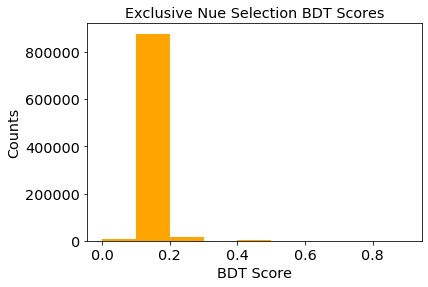

In [137]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [138]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'

Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

No handles with labels found to put in legend.


n_events here =  904362

1.0
1
{'ext': 0.5612087579382191}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
1
2
3
current_total  0
total  0.5612087579382191
[]

SUMS
[]
[]

Wanted List:
[]

current_wanted_list  []
current_total_hist  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
n_ext  [0.56120876 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]

current n_tot  [0.56120876 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
total array  [0.1366687]
total weight array  [0.56120876]
Returning
{'ext': 0.5612087579382191}
nslice

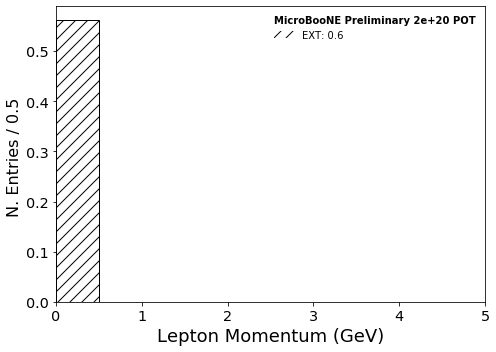

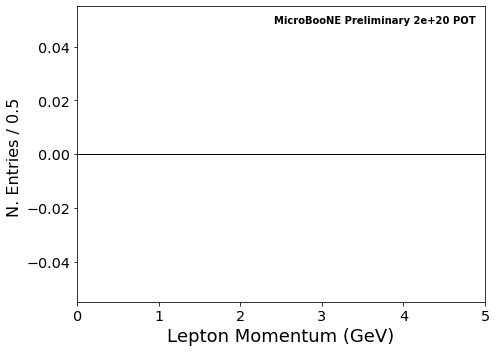

In [152]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_ext.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_ext.iloc[start:end]

    samples = {
        "nue_ext": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    # The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
    extratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99
    # We scale down the EXT to account for neutrino occupancy
    scalingEXT = 0.98
    

    # NU
    weights = { #full sample mc = 0.38  
                "ext" : extratio * SPLIT * scalingEXT, #set0 
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        currentsample = "nue_ext",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


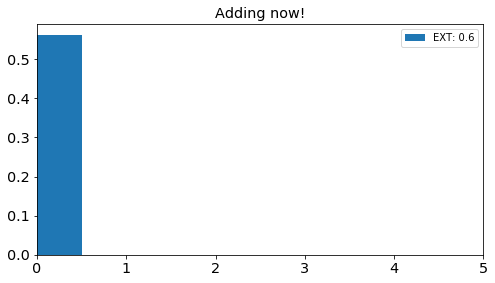

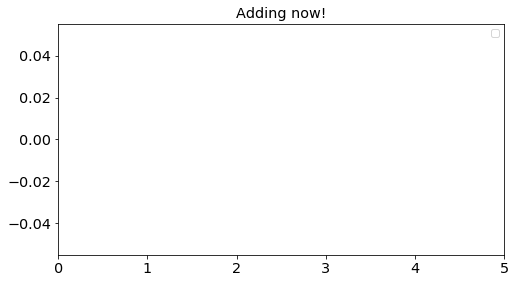

In [153]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i],
                weights=list(weightss[i]),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [154]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = np.concatenate(varss)
weightss_tot = np.concatenate(weightss)

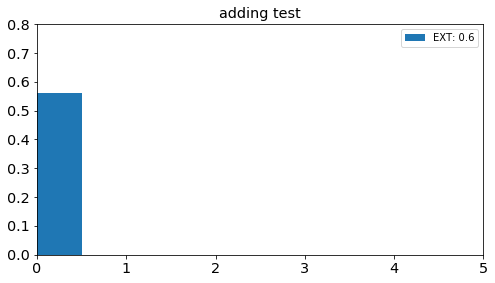

In [155]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = labss


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 0.8])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 0.8])

nue_stacked = nue_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [156]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 2

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [157]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)


######full trueE
#vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_recoE_usingSelection.csv')
#weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_recoE_usingSelection.csv')
########angleDiff
#vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
#weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
########leptonMom
vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')

Will need to add errors later!

## NUE_DATA SAMPLE

In [158]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
#full sample
BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND

#actually fetch datasets
nue_data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_data]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_data = nue_data.pandas.df(nue_variables, flatten=False)

['run', 'flash_time', 'trk_energy', 'nslice', 'CosmicIPAll3D', 'n_tracks_contained', 'selected', 'shrsubclusters1', 'contained_fraction', 'shr_tkfit_dedx_Y', 'reco_nu_vtx_sce_z', 'shrsubclusters0', 'shr_energy_tot_cali', 'shr_energy_cali', 'shrmoliereavg', 'shr_distance', 'tksh_angle', 'shr_px', 'sub', 'shr_tkfit_nhits_V', 'shr_tkfit_nhits_Y', 'shr_tkfit_nhits_U', 'n_tracks', 'n_showers_contained', 'evt', 'shr_tkfit_dedx_U', 'n_showers', 'shrsubclusters2', 'trk_score_v', 'shr_theta', 'trkshrhitdist2', 'topological_score', 'ccnc', 'npion', 'reco_nu_vtx_sce_x', 'hits_ratio', 'slnunhits', 'shr_tkfit_dedx_V', 'shr_score', 'shr_energy', 'shr_pz', 'nproton', 'shr_tkfit_npoints', 'reco_nu_vtx_sce_y', 'category', 'slnhits', 'tksh_distance', 'shr_phi', 'shr_py', 'trk_energy_tot', 'nu_pdg']


In [159]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [160]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [161]:
#This assumes the electron to be the leading shower
df_v = [nue_data]

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [162]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_data]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  55.84997606277466


In [163]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [164]:
df_v = [nue_data]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [165]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_data]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
nue_data["bnbdata"] = np.ones_like(nue_data["shr_energy"])


In [166]:
# add back the cosmic category, for background only
df_v = [nue_data]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [167]:
#Define signal catagories

nue_data["is_signal"] = nue_data["category"] == 11

Set up complete. Now on to BDT.

In [168]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [169]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [170]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_data]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(610496, 76)


In [171]:
datasets_bdt = nue_data

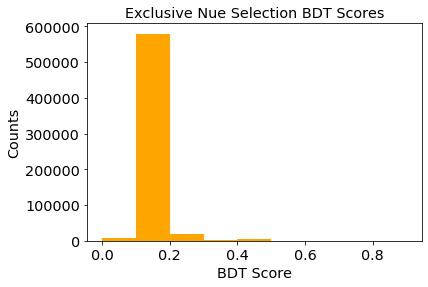

In [172]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [173]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'

Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

No handles with labels found to put in legend.


n_events here =  610496

1.0
1
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
1
2
3
current_total  0
[]

SUMS
[]
[]

Wanted List:
[]

current_wanted_list  []
current_total_hist  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

current n_tot  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
total array  []
total weight array  []
Returning
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and

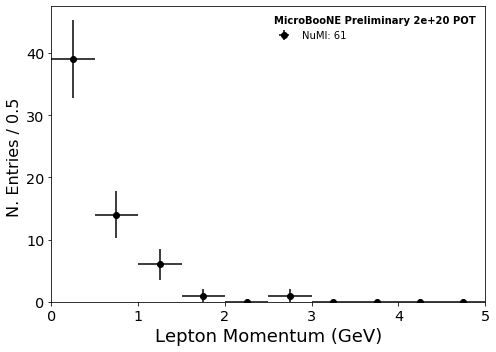

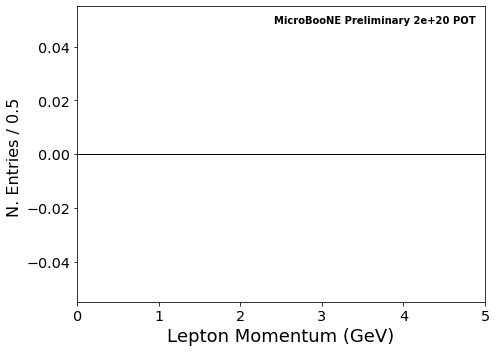

In [189]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_data.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_data.iloc[start:end]

    samples = {
        "nue_data": sample_set 
    }

    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    weights = {  
                }
    
    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        currentsample = "nue_data",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


[array([39, 14,  6,  1,  0,  1,  0,  0,  0,  0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]
[array([39, 14,  6,  1,  0,  1,  0,  0,  0,  0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


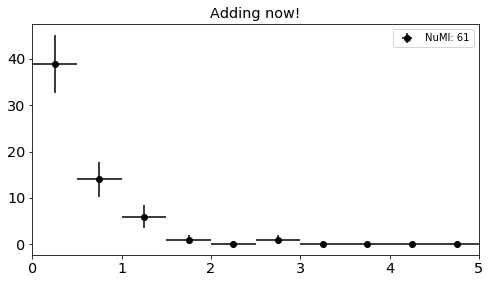

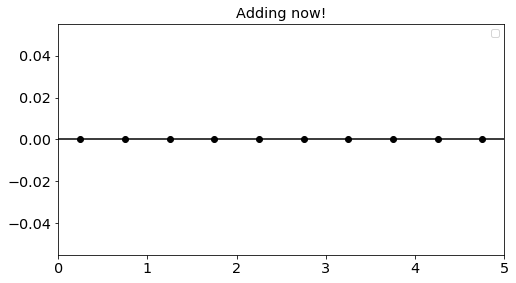

In [190]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    current_bincenters =  np.arange(0.25, 5.25, 0.5)
    current_bin_size = 0.5
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff
    #current_bincenters =  np.arange(-0.9, 1.1, 0.2)
    #current_bin_size = 0.25
    
    print(varss)
    
    nue_ax1.errorbar(
                current_bincenters,
                varss[i],
                xerr=current_bin_size/2,
                yerr=weightss[i],
                fmt='ko',
                label="NuMI: %i" % sum(varss[i]) if sum(varss[i]) else "")
    
    plt.title("Adding now!")
    plt.legend()

In [191]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = sum(varss)
print(weightss[0][0])
#sum errors? will need to change if splitting data
weightss_tot = weightss[0][0]

[6.244998   3.74165739 2.44948974 1.         0.         1.
 0.         0.         0.         0.        ]


[39 14  6  1  0  1  0  0  0  0]


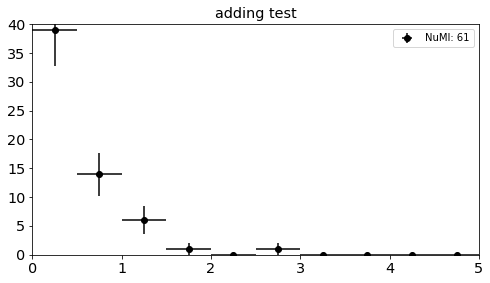

In [192]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = labss

nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 40])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 33])

print(varss_tot)

nue_ax1.errorbar(
            current_bincenters,
            varss_tot,
            xerr=current_bin_size/2,
            yerr=weightss_tot,
            fmt='ko',
            label="NuMI: %i" % sum(varss_tot) if sum(varss_tot) else "")


plt.title("adding test")
plt.legend()

In [193]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)


######full trueE
#vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_recoE_usingSelection.csv')
#weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_recoE_usingSelection.csv')
########angleDiff
#vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
#weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
########leptonMom
vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')

## NUMU_MC SAMPLE (and Nue)

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#full sample
NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune

#actually fetch datasets
numu_mc  = uproot.open(ls.ntuple_path+NU+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_mc]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon",
        "reco_e",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['reco_nu_vtx_y', 'evt', 'slpdg', 'interaction', 'reco_nu_vtx_sce_x', 'trk_sce_end_x_v', 'slnhits', 'CosmicIPAll3D', 'CosmicDirAll3D', 'trk_theta', 'trk_energy_muon', 'pion_e', 'slnunhits', 'trk_mcs_muon_mom_v', 'npion', 'mc_pdg', 'nproton', 'backtracked_pdg', '_opfilter_pe_veto', 'category', 'pi0truth_elec_etot', '_opfilter_pe_beam', 'reco_e', 'nu_pdg', 'true_e_visible', 'reco_nu_vtx_sce_y', 'reco_nu_vtx_x', 'sub', 'run', 'trk_sce_end_y_v', 'trk_range_muon_mom_v', 'nslice', 'trk_llr_pid_score_v', 'reco_nu_vtx_sce_z', 'pi0_e', 'slclustfrac', 'CosmicIP', 'isVtxInFiducial', 'evnunhits', 'reco_nu_vtx_z', 'flash_pe', 'muon_e', 'trk_phi', 'trk_sce_start_x_v', 'ccnc', 'topological_score', 'trk_sce_end_z_v', 'npi0', 'nmuon']


In [6]:
import time
s = time.time()

import pandas as pandas

mc_var   = numu_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+numu_varMC

# This needs modifications (add variables from above)
uproot_v = [numu_mc] 
var_v    = [mc_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_mc = CVDF

s2 = time.time()

print("runtime = ", s2-s)

trk_llr_pid_v  [[0.73482436] [-0.70503384 0.5525445 -3.4028235e+38] [] ... [] [] [0.9896643 0.5211012 0.04211452]]
trk_score_v  [[0.8417371] [0.9219987 0.9697223 -1.0] [] ... [] [] [1.0 0.011713999 0.47363594]]
Here:
trk_range_muon_mom_v  [[0.2488809] [0.121225685 0.109380074 -3.4028235e+38] [] ... [] [] [1.2258223 0.20158982 0.05128334]]
trk_mcs_muon_mom_v  [[0.27999988] [0.40099838 14.999432 -3.4028235e+38] [] ... [] [] [1.9420298 0.13100009 14.993429]]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


runtime =  1487.3389625549316


In [7]:
df_v = [numu_mc]
#print(df_v)
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [8]:
s = time.time()

df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
     # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    
    
s2 = time.time()
print("runtime = ", s2-s)

runtime =  41383.85077023506


In [9]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']
    #print(df['trk_sce_start_x_v'])
    #print(df['reco_nu_vtx_sce_x'])
    #print(df['nu_pdg'])

In [10]:
df_v = [numu_mc]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ]

In [11]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [12]:
df_v = [numu_mc]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [13]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_5306/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  51.01272749900818


In [14]:
numu_mc["is_signal"]   = numu_mc["category"] == 2
#print(numu_mc["is_signal"])

In [15]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [16]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [51]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    print(df['trk_mcs_muon_mom_v'])

entry
0                                    [0.27999988]
1         [0.40099838, 14.999432, -3.4028235e+38]
2                                              []
3                                    [0.26700005]
4                                              []
                           ...                   
914724                                         []
914725                    [0.31199953, 14.999432]
914726                                         []
914727                                         []
914728         [1.9420298, 0.13100009, 14.993429]
Name: trk_mcs_muon_mom_v, Length: 914729, dtype: object


In [17]:
numu_mc.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0", inplace=True)

In [18]:
"""
s = time.time()

for i,df in enumerate(df_v):
    df["muon_px"] = df["ccnc"].copy()
    df["muon_py"] = df["ccnc"].copy()
    df["muon_pz"] = df["ccnc"].copy()
    for j, row in df.iterrows():
        pdg_vector = df["mc_pdg"].loc[j][0]
        px_vector = df["mc_px"].loc[j]
        py_vector = df["mc_py"].loc[j]
        pz_vector = df["mc_pz"].loc[j]
        result = np.where(pdg_vector==13)[0]
        if np.size(result):
            df.loc[j, "muon_px"] = px_vector[result][0]
            df.loc[j, "muon_py"] = py_vector[result][0]
            df.loc[j, "muon_pz"] = pz_vector[result][0]   
            
    print(df["muon_px"])

print("")    
print("==========================")
s2 = time.time()
print("runetime = ", s2-s)
"""
df_v = [numu_mc]
#removeGenieTune = False
#for i,df in enumerate(df_v):
#    print(df['muon_momentum'])

#if track is stopped in fiducial volume
#    then use stoppingmom
#else
#    use other mom
    
#set up this new variable for each one in  the dataframe

#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_sce_end_z_v"].copy()
    for j, row in df.iterrows():
        if (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])

entry
61        0.411006
214       0.400905
278       0.264861
341       0.178695
342       0.527353
            ...   
914563    0.208389
914600     1.44101
914616    0.375773
914619    0.718173
914652    0.875998
Name: muon_mom, Length: 24675, dtype: object


In [19]:
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    #df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    #df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    #df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    #df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])

In [20]:
numu_mc   = numu_mc.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_mc]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)

Set up complete. 

In [21]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

#nue = mc.query("(abs(nu_pdg) == 12 and ccnc == 0)") 
#nueMC = mc.query("(abs(nu_pdg) == 14 & ccnc == 0)")
##CHANGE
numu_nue   = numu_mc.query("(abs(nu_pdg) == 12 & ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55)")



samples = {
    "numu_mc"  : numu_mc,
    "numu_nue" : numu_nue
}

scaling   = 1
pot       =  2e+20             
mcratio   = pot/2.33652e+21
#nueratio  = pot/2.37838e+22

SPLIT = 1.0
scaling = 1

weights = { "numu_mc"  : mcratio  * SPLIT * scaling,
            "numu_nue"  : mcratio  * SPLIT * scaling   
}

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'numu_mc': 0.08559738414394057, 'numu_nue': 0.08559738414394057}


In [22]:
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0"

Now plot.

n_events here =  24675

1.0
1
{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
1
2
3
current_total  2095.08215364408
[11.37245766423247, 23.808493146521457, 52.58612181993235, 277.01247397806776]

SUMS
[38.71722912326027, 118.59726318486979, 261.5911698293031, 543.4910566863057, 2095.0821536440803]
[79.88003406160952, 142.9939066444333, 281.89988685700257, 1551.5910969577747]

Wanted List:
[8.662058138085861, 4.652635909301491, 2.5394299751974523, 4.975994519994335, 4.549005051784015, 6.561546425854462, 9.094938050449876, 14.895771779210136, 23.808493146521457, 63.25403364803426]

current_wanted_list  [8.66205813

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Returning
{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
Had to return early (colour sorting).


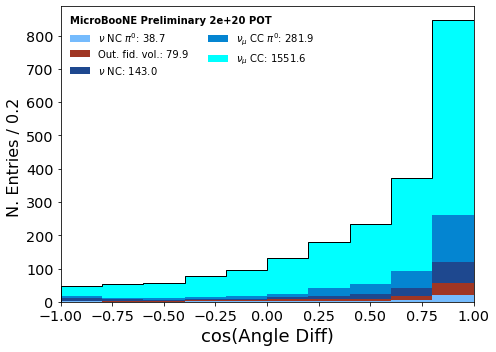

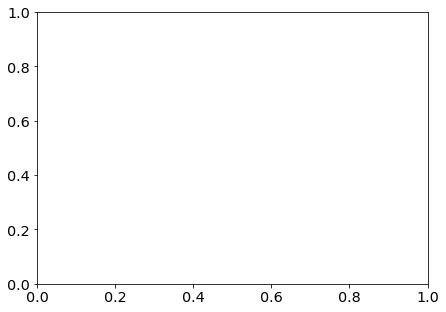

In [58]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "numu_mc": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    mcratio   = pot/2.33652e+21

    # NUE
    weights = { #full sample mc = 0.38
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',10,(0.0, 10.0),"Particle Tests"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
No handles with labels found to put in legend.


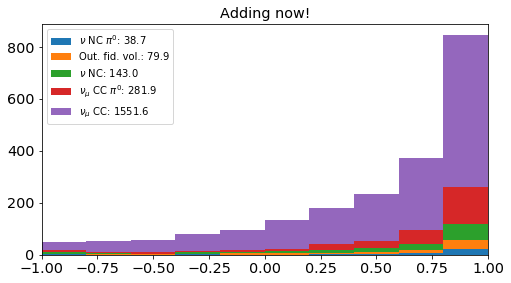

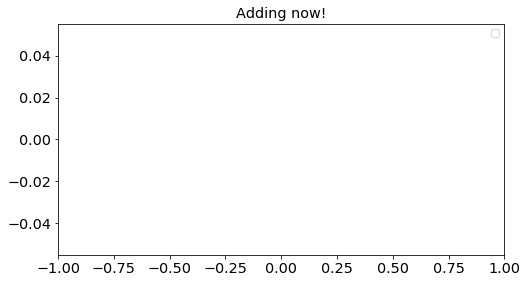

In [59]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [60]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

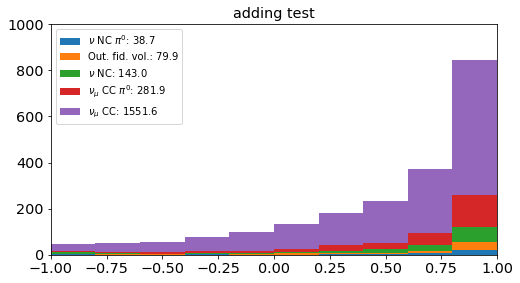

In [61]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
#nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 1500])

#AngleDiff
nue_ax1.set_xlim([-1, 1])
nue_ax1.set_ylim([0, 1000])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [62]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 3

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[11.37245766423247, 23.808493146521457, 52.58612181993235, 277.01247397806776]

SUMS
[38.71722912326027, 118.59726318486979, 261.5911698293031, 543.4910566863057, 2095.0821536440803]
[79.88003406160952, 142.9939066444333, 281.89988685700257, 1551.5910969577747]

Wanted List:
[31.172518312314853, 41.72202604654176, 47.001365612618685, 63.73950058997194, 78.36879739259305, 108.70017068518092, 138.63883113773255, 179.8249736798345, 277.01247397806776, 585.4104395229184]

[31.172518312314853, 41.72202604654176, 47.001365612618685, 63.73950058997194, 78.36879739259305, 108.70017068518092, 138.63883113773255, 179.8249736798345, 277.01247397806776, 585.4104395229184]


In [44]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)


######full trueE
#vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection.csv')
#weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection.csv')
########angleDiff
##vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
#weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
########leptonMom
#vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
#weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


n_events here =  315

1.0
1
{'numu_nue': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
1
2
3
current_total  0
[]

SUMS
[]
[]

Wanted List:
[]

current_wanted_list  []
current_total_hist  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

current n_tot  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
total array  []
total weight array  []
Returning
{'numu_nue': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036

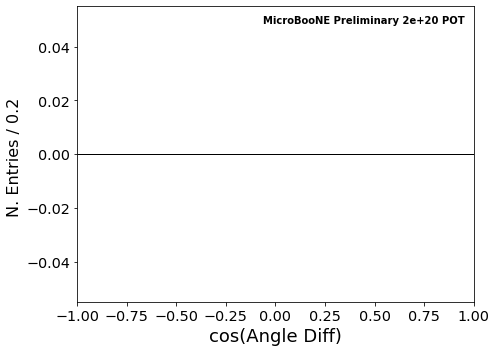

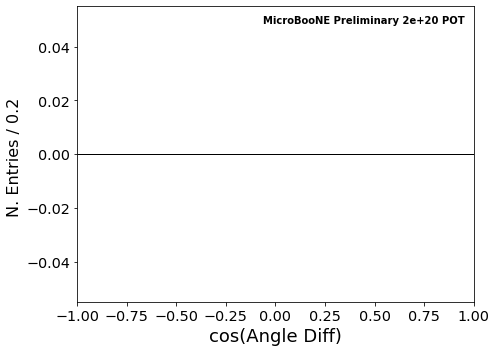

In [63]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []
if n_events > 0:
    print(n_events/batch_size)
    print(int(n_events/batch_size))

    for i in range(int(n_events/batch_size)+1):
        start = i*batch_size
        if (start + batch_size) < n_events:
            end = start + batch_size
        else:
            end = n_events
        sample_set = numu_nue.iloc[start:end]

        samples = {
            #"nue_nue": nue_nue
            "numu_nue": sample_set 
        }


        scaling = 1
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        mcratio   = pot/2.33652e+21

        # NUE
        weights = { #full sample mc = 0.38
                    "numu_nue"  : mcratio  * SPLIT * scaling
        }


        my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
        print(weights)


        #Now check on a variable
        #Remember to change the plotter keys between truth and mc

        #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
        VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
        #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"


        var, weight, label = my_plotter.plot_variable(
            VARIABLE,
            query= NUMU_SEL_QUERY,
            currentsample = "numu_nue",
            kind="event_category",
            draw_sys  = True, 
            draw_geoSys = True, 
            draw_data = True,
            ratio=False,
            genieweight = "weightSplineTimesTuneTimesPPFX",  
            stacksort=3,
            title=XTIT,
            bins=BINS,
            range=RANGE
        )[0:3]

        varss.append(var)
        weightss.append(weight)
        labss.append(label)

In [64]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
    weights = { #full sample mc = 0.38
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        #query= truthsel_nue,
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  24675

0.616875
0
{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0& muon_mom <= 5 & muon_mom >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_mc

err numu mc: 
[1.21487531e+02 4.35511660e+01 9.81073540e+00 2.52045779e+00
 6.15460622e-01 2.19807365e-01 3.66345609e-02 1.46538243e-02
 1.46538243e-02 0.00000000e+00]
detsys numu mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [1.4201572e+03 5.1921466e+02 1.1963616e+02 2.9308226e+01 6.5470743e+00
 2.4993882e+00 4.1144383e-01 1.6277137e-01 1.3064933e-01 0.0000000e+00]
Returning


In [65]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

numu_mc_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_mc_stat_errs_selected = total_sels

total errs =  [121.48753072866303, 43.55116595206399, 9.810735398690055, 2.520457787266153, 0.6154606224719675, 0.21980736516855984, 0.03663456086142664, 0.014653824344570656, 0.014653824344570656, 0.0]
total selected =  [1420.1572265625, 519.2146606445312, 119.63616180419922, 29.308225631713867, 6.547074317932129, 2.4993882179260254, 0.411443829536438, 0.16277137398719788, 0.13064932823181152, 0.0]


In [66]:
"""
np.savetxt("numu_mc_stat_errs_full_catsel_nopions_recoE_usingSelection.csv", 
           numu_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_recoE_usingSelection.csv", 
           numu_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

"""


#########################
#####angleDiff###########
##########################
"""
np.savetxt("numu_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
           numu_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
           numu_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

"""

#########################
#####leptonMom###########
##########################

np.savetxt("numu_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
           numu_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
           numu_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')


### Sys Errors

In [30]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsPPFX",
        #category_query = " and category == 2",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)

n_events here =  24675

0.616875
0
{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0& muon_mom <= 5 & muon_mom >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
        0     1     2     3     4     5     6     7     8     9    ...   590  \
0      1308   496  1938   760  1833  1414   881  1704  1812  1575  ...  1260   
1       741   844   665   925   406   522   588   611   457   563  ...   483   
2       500  1080   438   246  1169   385   553   537   444   372  ...   469   
3       402  2818  1874  1255   361    32   343   672   804    71  ...  1976   
4       547   568   692   629   672   696   633   621   626   705  ...   

In [31]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_ppfx.append(sum(masterlist[a]))


final_ncvs_numu_mc_ppfx = sum(n_cv_tots)


#------------------------
frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [32]:
"""
np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ns_numu_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ncvs_numu_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection.csv')
total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection.csv')
total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection.csv')
"""
"""
###############################
######angleDiff##########
######################

np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_numu_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_numu_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""

###############################
######leptonMom##########
######################

np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_numu_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_numu_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')


In [39]:
#############################
##### weightsgenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsGenie",
        #category_query = " and category == 2",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)

n_events here =  24675

0.616875
0
{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0& muon_mom <= 5 & muon_mom >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
        0     1     2     3     4     5     6     7     8     9    ...   590  \
0      1351  1050   861  1276  1085  1398  1144  1169  1298  1306  ...  1362   
1       881   529   659  1166   598   457  1029   585  1626   446  ...   832   
2       630   853   390  1343     1  1058  1340  1192   670  1329  ...  1007   
3      1243  1130  1114  1196  1146  1237  1162  1128  1195  1234  ...  1244   
4      1039  1220  1242   944   791   920   931   828   969  1027  ...   

In [40]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_genie.append(sum(masterlist[a]))

final_ncvs_numu_mc_genie = sum(n_cv_tots)

##################################################

frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [41]:
"""
np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ns_numu_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ncvs_numu_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection.csv')
total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection.csv')
total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection.csv')
"""
"""
###########################
#####angleDiff###########
##########################

np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_numu_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_numu_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""

###########################
#####leptonMom###########
##########################

np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_numu_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_numu_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')


In [48]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsReint",
        #category_query = " and category == 2",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)

n_events here =  24675

0.616875
0
{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0& muon_mom <= 5 & muon_mom >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
        0     1     2     3     4     5     6     7     8     9    ...   990  \
0      1104  1302   736   987  1141  1068  1118  1085   859  1056  ...  1186   
1      1094  1318   680   996  1091  1087  1246  1092   888  1024  ...  1276   
2       970   915  1045  1004   952   985   983   978  1039   979  ...   961   
3       978   936  1040  1002   968   987   980   983  1027   986  ...   965   
4       977   934  1039  1003   965   987   982   983  1029   985  ...   

In [49]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_reint.append(sum(masterlist[a]))

final_ncvs_numu_mc_reint = sum(n_cv_tots)

###################################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
    
    
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)

In [50]:
"""
np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ns_numu_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection.csv", 
           final_ncvs_numu_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection.csv')
total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection.csv')
total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection.csv')
"""

#############################
#####angleDiff##########
#######################
"""
np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_numu_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_numu_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
"""

#############################
#####leptonMom##########
#######################

np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_numu_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_numu_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')


In [57]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        #category_query = " and category == 2",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)

n_events here =  24675
0.616875
1
{'numu_mc': 0.08559738414394057}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0& muon_mom <= 5 & muon_mom >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------



In [58]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_mc_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_geo.append(sum(masterlist[a]))

final_ncvs_numu_mc_geo = sum(n_cv_tots)
    
for x in range(len(final_ns_numu_mc_geo)):
    final_ns_numu_mc_geo[x] = np.concatenate((final_ns_numu_mc_geo[x][0], final_ns_numu_mc_geo[x][1]))
    
#############################################################
frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [59]:
"""
np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection.csv", 
           final_ns_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection.csv", 
           final_ncvs_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_recoE_usingSelection.csv')
total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection.csv')
total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection.csv')
"""
########################
####angleDiff##########
#######################
"""

np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ns_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
           final_ncvs_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection.csv')
total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection.csv')
total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection.csv')
"""

########################
####leptonMom##########
#######################


np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ns_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
           final_ncvs_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv')
total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv')


## NUMU_DIRT SAMPLE

In [4]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
#full sample
DRT  = '/prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'  +ls.APPEND

#actually fetch datasets
numu_dirt  = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_dirt]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon",
        "reco_e",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['evt', '_opfilter_pe_veto', 'CosmicIP', 'true_e_visible', 'slpdg', 'reco_nu_vtx_sce_y', 'interaction', 'muon_e', 'evnunhits', 'trk_sce_end_z_v', 'CosmicIPAll3D', 'topological_score', 'trk_sce_end_y_v', 'trk_sce_end_x_v', 'reco_e', 'trk_energy_muon', 'nslice', 'reco_nu_vtx_sce_z', 'pi0truth_elec_etot', 'backtracked_pdg', 'trk_sce_start_x_v', 'slclustfrac', 'trk_mcs_muon_mom_v', 'sub', 'nu_pdg', 'run', 'trk_range_muon_mom_v', 'ccnc', 'nmuon', 'npi0', 'CosmicDirAll3D', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_y', 'pi0_e', 'category', 'npion', 'slnunhits', 'reco_nu_vtx_z', 'trk_theta', 'slnhits', 'trk_phi', 'pion_e', 'isVtxInFiducial', '_opfilter_pe_beam', 'nproton', 'reco_nu_vtx_x', 'flash_pe', 'mc_pdg', 'trk_llr_pid_score_v']


In [5]:
import time
s = time.time()

import pandas as pandas

dirt_var = numu_variables + numu_varMC + WEIGHTS + SYSTEMATICS

# This needs modifications (add variables from above)
uproot_v = [numu_dirt] 
var_v    = [dirt_var] 



for ii, CV in enumerate(uproot_v):
    print("1")
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    print()
    print("2")
    load_data_run123.process_uproot_numu(CV,CVDF)
    print("3")
    if ii == 0:
        print("4")
        numu_dirt =  CVDF

s2 = time.time()

print("runtime = ", s2-s)

1

2
trk_llr_pid_v  [[] [] [] ... [] [] []]
trk_score_v  [[] [] [] ... [] [] []]
Here:
trk_range_muon_mom_v  [[] [] [] ... [] [] []]
trk_mcs_muon_mom_v  [[] [] [] ... [] [] []]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


3
4
runtime =  221.62160468101501


In [6]:
df_v = [numu_dirt]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [7]:
s = time.time()

df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    """
     # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    """
    
s2 = time.time()
print("runtime = ", s2-s)

runtime =  0.1445326805114746


In [8]:
df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']

In [9]:
df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [10]:
df_v = [numu_dirt]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [11]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_4334/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  13.95392370223999


In [12]:
numu_dirt["is_signal"]   = numu_dirt["category"] == 2
#print(numu_mc["is_signal"])

In [13]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [14]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [15]:
df_v = [numu_dirt]
    
#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
for i,df in enumerate(df_v):
    print(df["n_muons_tot"])

entry
0         0
1         0
2         0
3         0
4         0
         ..
569501    0
569502    0
569503    0
569504    0
569505    0
Name: n_muons_tot, Length: 569506, dtype: int64


In [16]:
numu_dirt.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0", inplace=True)

In [17]:
df_v = [numu_dirt]
    
#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_range_muon_mom_v"].copy()
    for j, row in df.iterrows():
        if (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])

entry
1138      0.241054
1205      0.472777
3527      0.317174
4255      0.392615
5356      0.921958
            ...   
566111    0.549741
566137    0.222463
566221    0.395383
567666     1.10804
569370       1.053
Name: muon_mom, Length: 408, dtype: object


In [18]:
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    #df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    #df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    #df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    #df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])
    print(df['cosNu_Angle_Numi_Muon'])
    print(df['reco_nu_vtx_sce_x'])

entry
1138     -0.766328
1205      0.794024
3527      0.341467
4255     -0.800791
5356      0.974622
            ...   
566111    0.735774
566137    0.637509
566221   -0.866412
567666   -0.386616
569370    0.974186
Name: cosNu_Angle_Numi_Muon, Length: 408, dtype: float64
entry
1138       13.671485
1205      112.259079
3527      226.951233
4255      110.254593
5356        6.271605
             ...    
566111    108.329697
566137     82.859444
566221     98.982269
567666     20.502098
569370      5.779076
Name: reco_nu_vtx_sce_x, Length: 408, dtype: float32


In [19]:
numu_dirt   = numu_dirt.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)

Set up complete.

In [20]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_dirt"  : numu_dirt
}

pot       =  2e+20
dirtratio = pot/1.42143e+21

SPLIT = 1.0
scaling = 1
scalingDRT = 0.60 #0.35

weights = {  "numu_dirt": dirtratio* SPLIT * scalingDRT,  
}

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'numu_dirt': 0.08442202570650682}


In [21]:
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0"

n_events here =  408

1.0
1
{'numu_dirt': 0.08442202570650682}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  numu_dirt
1
2
3
current_total  32.78156381547465
[]

SUMS
[]
[]

Wanted List:
[]

current_wanted_list  []
current_total_hist  [1.24139468 1.93782728 0.83287019 1.67445751 3.68132883 3.58228909
 4.11541595 2.90930245 3.83672151 8.96995632]

current n_tot  [1.24139468 1.93782728 0.83287019 1.67445751 3.68132883 3.58228909
 4.11541595 2.90930245 3.83672151 8.96995632]
total array  [-7.66327573e-01  7.94023835e-01  3.41467342e-01 -8.00791434e-01
  9.74621502e-01 -1.44956834e-01  7.20794697e-01  3.93827377e-01
  8.386675

Had to return early (colour sorting).


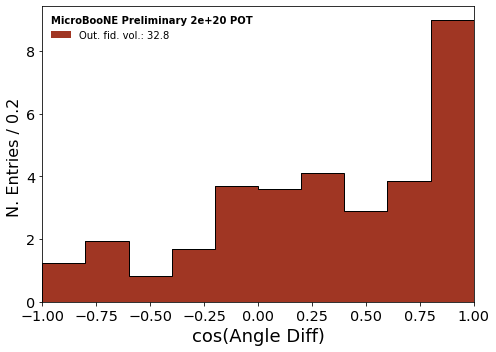

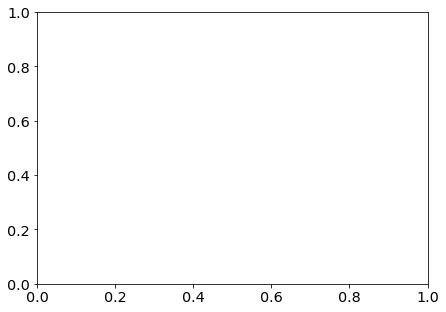

In [22]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    dirtratio = pot/1.42143e+21
    scalingDRT = 0.60 #0.35

    # NUE
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT,
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        currentsample = "numu_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


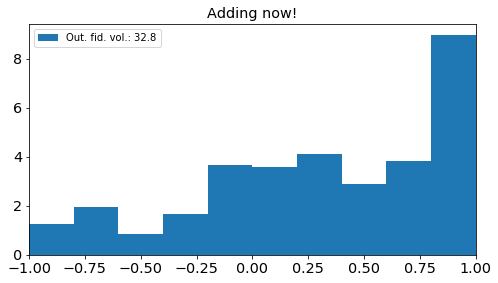

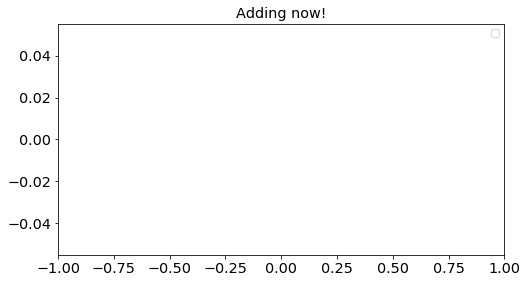

In [23]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [24]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

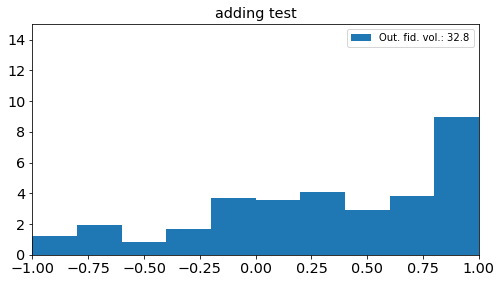

In [25]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
#nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 30])

##AngleDiff
nue_ax1.set_xlim([-1, 1])
nue_ax1.set_ylim([0, 15])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [26]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [27]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)


######full trueE
#vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_recoE_usingSelection.csv')
#weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_recoE_usingSelection.csv')
########angleDiff
#vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
#weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
########leptonMom
#vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
#weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')

In [36]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
    scalingDRT = 0.35
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        #query= truthsel_nue,
        currentsample = "numu_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  408

0.0102
0
{'numu_dirt': 0.049246181662128984}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0& muon_mom <= 5 & muon_mom >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_dirt

err numu dirt: 
[0.81486263 0.15278674 0.0169763  0.00242519 0.         0.
 0.         0.         0.         0.        ]
detsys numu dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [15.427387    3.2632008   0.34490857  0.06037685  0.          0.
  0.          0.          0.          0.        ]
Returning


In [37]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

numu_dirt_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_dirt_stat_errs_selected = total_sels

total errs =  [0.8148626331886014, 0.15278674372286277, 0.016976304858095863, 0.002425186408299409, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
total selected =  [15.427387237548828, 3.2632007598876953, 0.34490856528282166, 0.0603768527507782, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [38]:
"""
np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_recoE_usingSelection.csv", 
           numu_dirt_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_recoE_usingSelection.csv", 
           numu_dirt_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

"""


#########################
#####angleDiff###########
##########################
"""
np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
           numu_dirt_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
           numu_dirt_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""

#########################
#####leptonMom###########
##########################

np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
           numu_dirt_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
           numu_dirt_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')


## NUMU_EXT

In [63]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
#full sample
EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND

#actually fetch datasets
numu_ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_ext]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon",
        "reco_e",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['run', 'evnunhits', 'slclustfrac', 'nslice', 'CosmicIPAll3D', 'CosmicIP', 'trk_sce_end_x_v', 'pi0_e', 'reco_nu_vtx_sce_z', 'pion_e', 'flash_pe', 'backtracked_pdg', 'interaction', 'sub', 'reco_nu_vtx_y', 'isVtxInFiducial', 'evt', 'reco_nu_vtx_z', 'trk_sce_end_y_v', 'true_e_visible', 'slpdg', 'CosmicDirAll3D', 'trk_sce_start_x_v', 'npi0', 'topological_score', 'trk_mcs_muon_mom_v', 'ccnc', 'nmuon', 'muon_e', 'npion', 'reco_nu_vtx_sce_x', 'trk_energy_muon', 'trk_llr_pid_score_v', 'slnunhits', 'trk_phi', 'nproton', 'trk_theta', 'mc_pdg', 'reco_nu_vtx_sce_y', 'category', 'slnhits', 'pi0truth_elec_etot', 'reco_nu_vtx_x', 'trk_sce_end_z_v', 'reco_e', 'trk_range_muon_mom_v', '_opfilter_pe_veto', '_opfilter_pe_beam', 'nu_pdg']


In [64]:
import time
s = time.time()

import pandas as pandas

ext_var  = numu_variables

# This needs modifications (add variables from above)
uproot_v = [numu_ext] 
var_v    = [ext_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_ext = CVDF

s2 = time.time()


trk_llr_pid_v  [[] [] [] ... [] [] []]
trk_score_v  [[] [] [] ... [] [] []]
Here:
trk_range_muon_mom_v  [[] [] [] ... [] [] []]
trk_mcs_muon_mom_v  [[] [] [] ... [] [] []]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [65]:
df_v = [numu_ext]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [66]:
df_v = [numu_ext]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

numu_ext["extdata"] = np.ones_like(numu_ext["isVtxInFiducial"])

In [67]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

runtime =  7.600602149963379


In [68]:
numu_ext["is_signal"]   = numu_ext["category"] == 2

In [69]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [70]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [71]:
numu_ext.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0", inplace=True)

In [72]:
df_v = [numu_ext]
    
#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
#for i,df in enumerate(df_v):
#    df["muon_mom"] = df["trk_range_muon_mom_v"].copy()
for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_range_muon_mom_v"].copy()
    for j, row in df.iterrows():
        if (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])

entry
7032      0.192857
9575      0.253589
12294     0.228936
13650     0.208716
14191     0.149407
            ...   
894137    0.266947
895153       0.167
897852     0.71253
898897    0.297465
902190    0.623877
Name: muon_mom, Length: 566, dtype: object


In [73]:
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    #df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    #df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    #df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    #df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])

Set up complete.

In [74]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_ext"  : numu_ext
}

pot       =  2e+20
extratio  = 5268051.0/9199232.74

SPLIT = 1.0
scaling = 1
scalingEXT = 0.98

weights = {   "ext" : extratio * SPLIT * scalingEXT, 
}

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'ext': 0.5612087579382191}


In [75]:
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0"

No handles with labels found to put in legend.


n_events here =  566

1.0
1
{'ext': 0.5612087579382191}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current_plotted_variable  [ 1.56632535e-01  5.25670536e-02 -7.55413466e-01  1.87565747e-02
 -5.73073009e-01  2.15079137e-01  2.57493092e-01  1.91182473e-01
 -1.13008800e-01  5.31694389e-01 -1.36800428e-01  2.38034863e-01
 -2.66422778e-01  3.40206389e-01 -1.29566327e-01  1.68806849e-01
  7.87802567e-01 -5.20103270e-01 -2.21879319e-01  4.67138266e-01
  9.74429780e-01 -1.83418635e-01 -2.57571228e-01  4.29917122e-01
 -1.99173293e-01  2.20998374e-01 -4.91829535e-02  4.19751599e-01
  6.18232530e-01  6.10997448e-02  7.49699563e-01 -7.18832643e-02
  9.

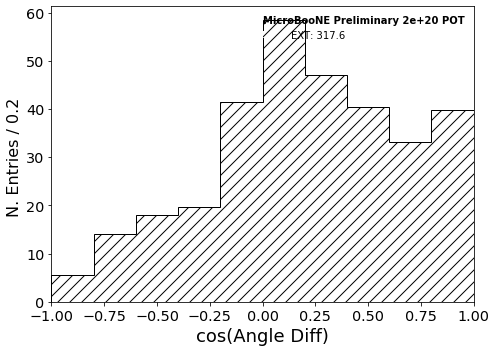

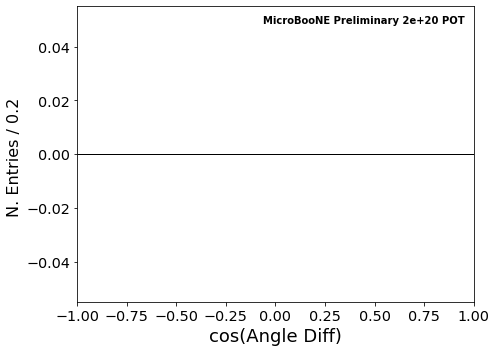

In [86]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_ext.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_ext.iloc[start:end]

    samples = {
        "numu_ext": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    extratio  = 5268051.0/9199232.74
    scalingEXT = 0.98
    
    # NUE
    weights = { "ext" : extratio * SPLIT * scalingEXT,
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        currentsample = "numu_ext",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


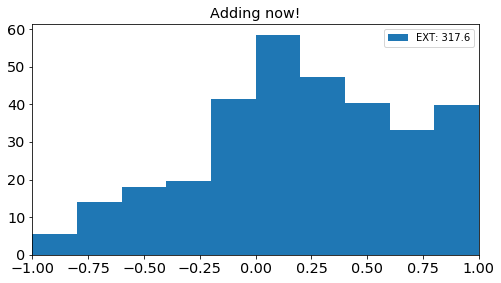

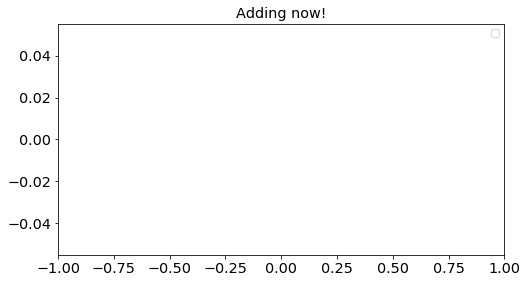

In [87]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i],
                weights=list(weightss[i]),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [88]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = np.concatenate(varss)
weightss_tot = np.concatenate(weightss)

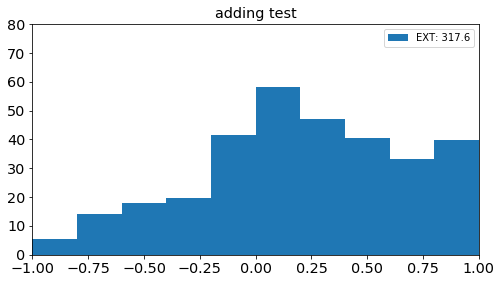

In [89]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = labss


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
#nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 300])

#AngleDiff
nue_ax1.set_xlim([-1, 1])
nue_ax1.set_ylim([0, 80])

nue_stacked = nue_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [90]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [91]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)


######full trueE
#vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_recoE_usingSelection.csv')
#weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_recoE_usingSelection.csv')
########angleDiff
vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
########leptonMom
#vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
#weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')

## NUMU_DATA SAMPLE

In [92]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
#full sample
BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND

#actually fetch datasets
numu_data  = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_data]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon",
        "reco_e",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['run', 'evnunhits', 'slclustfrac', 'nslice', 'CosmicIPAll3D', 'CosmicIP', 'trk_sce_end_x_v', 'pi0_e', 'reco_nu_vtx_sce_z', 'pion_e', 'flash_pe', 'backtracked_pdg', 'interaction', 'sub', 'reco_nu_vtx_y', 'isVtxInFiducial', 'evt', 'reco_nu_vtx_z', 'trk_sce_end_y_v', 'true_e_visible', 'slpdg', 'CosmicDirAll3D', 'trk_sce_start_x_v', 'npi0', 'topological_score', 'trk_mcs_muon_mom_v', 'ccnc', 'nmuon', 'muon_e', 'npion', 'reco_nu_vtx_sce_x', 'trk_energy_muon', 'trk_llr_pid_score_v', 'slnunhits', 'trk_phi', 'nproton', 'trk_theta', 'mc_pdg', 'reco_nu_vtx_sce_y', 'category', 'slnhits', 'pi0truth_elec_etot', 'reco_nu_vtx_x', 'trk_sce_end_z_v', 'reco_e', 'trk_range_muon_mom_v', '_opfilter_pe_veto', '_opfilter_pe_beam', 'nu_pdg']


In [93]:
import time
s = time.time()

import pandas as pandas

data_var  = numu_variables

# This needs modifications (add variables from above)
uproot_v = [numu_data] 
var_v    = [data_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_data = CVDF

s2 = time.time()


trk_llr_pid_v  [[] [] [0.61479425] ... [0.90935814] [] []]
trk_score_v  [[] [] [0.35534355] ... [0.9874813] [] []]
Here:
trk_range_muon_mom_v  [[] [] [0.11552857] ... [0.30664095] [] []]
trk_mcs_muon_mom_v  [[] [] [0.12300007] ... [0.34299913] [] []]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [94]:
df_v = [numu_data]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [95]:
df_v = [numu_data]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

numu_data["bnbdata"] = np.ones_like(numu_data["isVtxInFiducial"])

In [96]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_4366/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  5.810422658920288


In [97]:
numu_data["is_signal"]   = numu_data["category"] == 2

In [98]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [99]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [100]:
numu_data.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0", inplace=True)

In [101]:
df_v = [numu_data]
    
#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_range_muon_mom_v"].copy()
    for j, row in df.iterrows():
        if (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])

entry
199       0.750087
644       0.221772
861       0.235901
888        0.34727
934       0.458205
            ...   
609743    0.895527
609883     0.28735
610024    0.230272
610173    0.223865
610291    0.230306
Name: muon_mom, Length: 2435, dtype: object


In [102]:
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    #df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    #df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    #df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    #df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])

Set up complete.

In [103]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_data"  : numu_data
}

pot       =  2e+20

SPLIT = 1.0
scaling = 1

weights = { }

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{}


In [104]:
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0"

No handles with labels found to put in legend.


n_events here =  2435

1.0
1
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
1
2
3
current_total  0
[]

SUMS
[]
[]

Wanted List:
[]

current_wanted_list  []
current_total_hist  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

current n_tot  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
total array  []
total weight array  []
Returning
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 

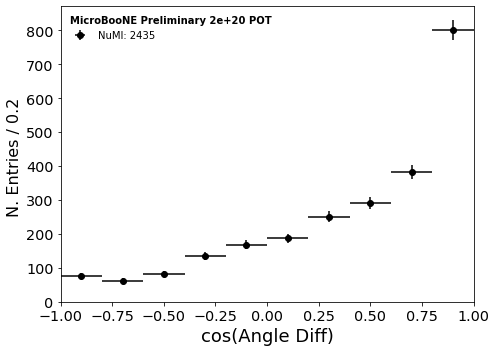

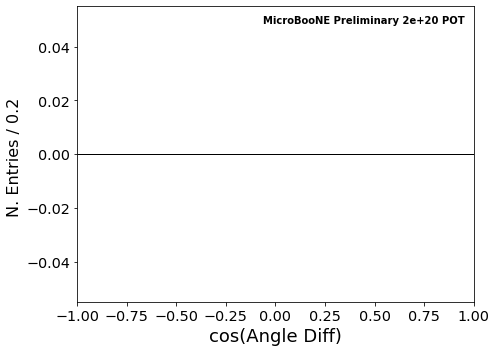

In [115]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_data.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_data.iloc[start:end]

    samples = {
        "numu_data": sample_set 
    }

    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    weights = {  
                }
    
    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        currentsample = "numu_data",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


[array([ 76,  62,  81, 135, 168, 187, 251, 291, 383, 801]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]
[array([ 76,  62,  81, 135, 168, 187, 251, 291, 383, 801]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


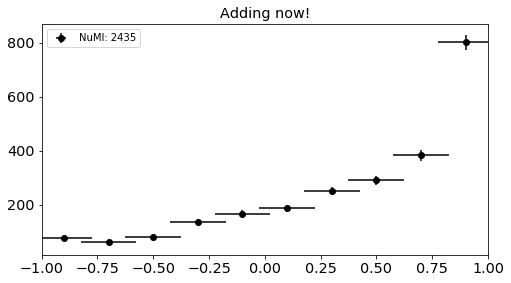

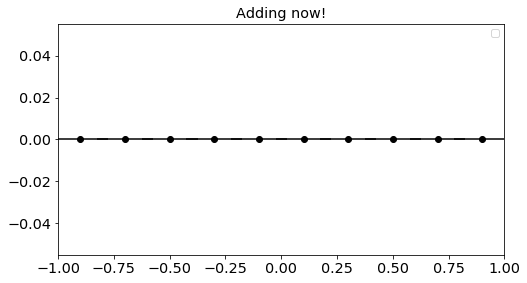

In [116]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #current_bincenters =  np.arange(0.25, 5.25, 0.5)
    #current_bin_size = 0.5
    nue_ax1.set_xlim([-1, 1])    #AngleDiff
    current_bincenters =  np.arange(-0.9, 1.1, 0.2)
    current_bin_size = 0.25
    
    print(varss)
    
    nue_ax1.errorbar(
                current_bincenters,
                varss[i],
                xerr=current_bin_size/2,
                yerr=weightss[i],
                fmt='ko',
                label="NuMI: %i" % sum(varss[i]) if sum(varss[i]) else "")
    
    plt.title("Adding now!")
    plt.legend()

In [117]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = sum(varss)
print(weightss[0][0])
#sum errors? will need to change if splitting data
weightss_tot = weightss[0][0]

[ 8.71779789  7.87400787  9.         11.61895004 12.9614814  13.67479433
 15.84297952 17.05872211 19.57038579 28.3019434 ]


[ 76  62  81 135 168 187 251 291 383 801]


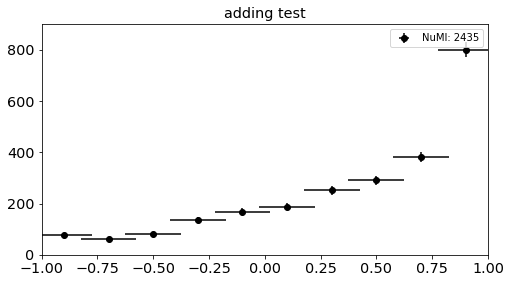

In [118]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = labss

nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
#nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 2000])

#AngleDiff
nue_ax1.set_xlim([-1,1])
nue_ax1.set_ylim([0, 900])

print(varss_tot)

nue_ax1.errorbar(
            current_bincenters,
            varss_tot,
            xerr=current_bin_size/2,
            yerr=weightss_tot,
            fmt='ko',
            label="NuMI: %i" % sum(varss_tot) if sum(varss_tot) else "")


plt.title("adding test")
plt.legend()

In [119]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)


#######full trueE
#vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_recoE_usingSelection.csv')
#weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_recoE_usingSelection.csv')
########angleDiff
vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
########leptonMom
#vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
#weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')